In [1]:
import pandas as pd
import numpy as np

In [2]:
from sklearn import metrics
from sklearn.preprocessing import StandardScaler

from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

In [3]:
import matplotlib.pyplot as plt

In [4]:
from joblib import dump, load

In [5]:
import shap

### 1. Loading GSEA scores and cluster labels

In [11]:
gsea = pd.read_csv('gsea_scores.csv', index_col=0)
gsea.shape

(1814, 18)

In [12]:
kirc_gsea = gsea[gsea['Sample_Type'] == 'KIRC_tumor']
kirc_gsea.shape

(475, 18)

In [13]:
kirc_gsea = kirc_gsea.drop('Sample_Type', axis=1)
kirc_gsea.shape

(475, 17)

In [14]:
samples = list(kirc_gsea.index)
features = list(kirc_gsea.columns)

In [15]:
scaler = StandardScaler().fit(kirc_gsea)
kirc_gsea_scaled = scaler.transform(kirc_gsea) # standardization of datasets

kirc_gsea_scaled = pd.DataFrame(kirc_gsea_scaled, index=samples, columns=features)
kirc_gsea_scaled

,RBPJL,SNAI2,PAX5,RARB,WT1,EGR1,RBPJ,LEF1,ARNT,CREB1,SRF,MEF2C,EPAS1,GATA4,HIF1A,PAX8,AHR
TCGA.B2.5641.01A.01R.1541.07,-0.490675,-0.719644,0.285699,-0.544927,0.549323,-0.644974,-0.075046,-0.680085,-0.192808,0.539172,0.455857,0.905694,0.401336,-0.334364,-0.308029,0.657149,-1.137724
TCGA.A3.3362.01A.02R.1325.07,0.726957,-0.052959,-0.523875,0.659367,-0.895923,0.041670,0.306888,-0.615878,0.985968,-0.403959,0.558185,-0.768811,0.164517,-0.943707,-0.570741,0.465772,0.709094
TCGA.A3.A6NL.01A.11R.A33J.07,0.324727,0.671787,0.432712,0.234604,-0.241725,0.769687,1.202441,-0.231788,0.114281,0.266096,0.677812,-0.303906,0.194540,-1.215842,-0.191647,1.150532,0.563945
TCGA.BP.5178.01A.01R.1426.07,0.756228,0.292934,2.003398,-0.903113,1.085854,-0.754869,-0.578393,1.141026,-1.406613,-1.481043,0.039011,1.052746,0.041470,0.917185,0.342880,0.222151,-3.247148
TCGA.BP.4756.01A.01R.1289.07,0.404623,-2.185154,0.393251,0.336141,0.003976,-2.648219,-2.460740,-0.167533,-0.704519,-1.580137,-1.544280,-0.779306,-1.828877,1.566625,0.866511,0.374481,-1.034220
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA.BP.5196.01A.01R.1426.07,0.441016,0.774614,1.173632,0.179758,0.584846,0.790392,0.279138,1.258185,-0.270865,0.052383,0.075851,-0.004028,0.240465,0.837212,1.145066,-1.052441,0.180227
TCGA.B8.4622.01A.02R.1277.07,0.093433,0.218931,0.087305,-0.424472,-0.315171,0.173427,0.189540,-0.648756,0.656867,-0.038675,1.467431,0.560899,0.495145,0.470838,-0.642535,0.746361,0.464668
TCGA.B0.5077.01A.01R.1334.07,-0.665550,0.044285,0.110603,0.212062,-0.423883,0.409681,0.681902,0.036981,1.009190,0.066993,-0.366627,-0.562292,0.287096,-0.113947,0.013129,0.679278,0.495335
TCGA.AK.3465.01A.02R.1325.07,1.445124,-2.848785,-1.139638,0.110064,-1.536370,-2.835338,-1.985213,-0.032207,-3.461025,-3.187754,-3.399458,-2.056217,-3.170111,0.837401,2.125613,-0.957897,-0.195847


In [16]:
# loading labels
cluster_idx = pd.read_csv('cluster_res.csv', index_col=0)
cluster_idx.head()

,Cluster_Idx
Sample,
TCGA.CW.6090.01A.11R.1672.07,0
TCGA.B0.4700.01A.02R.1541.07,0
TCGA.BP.4777.01A.01R.1289.07,0
TCGA.B4.5835.01A.11R.1672.07,0
TCGA.BP.4797.01A.01R.1305.07,0


In [17]:
labels = cluster_idx.loc[samples]
labels = list(labels['Cluster_Idx'])

### 2. Evaluating the machine learning model

In [18]:
X_train, X_test, y_train, y_test = train_test_split(kirc_gsea_scaled.values, labels, test_size=0.4, random_state=11)

In [19]:
# Five-fold corss-validation
clf = svm.SVC(kernel='linear', C=1, random_state=100)

acc_scores = cross_val_score(clf, X_train, y_train, cv=5)
print("%0.2f accuracy with a standard deviation of %0.2f in cross-validation" % (acc_scores.mean(), acc_scores.std()))

f1_scores = cross_val_score(clf, X_train, y_train, cv=5, scoring='f1_macro')
print("%0.2f f1_macro with a standard deviation of %0.2f in cross-validation" % (f1_scores.mean(), f1_scores.std()))

0.97 accuracy with a standard deviation of 0.01 in cross-validation
0.96 f1_macro with a standard deviation of 0.01 in cross-validation


In [20]:
clf = svm.SVC(kernel='linear', C=1, random_state=100).fit(X_train, y_train)
scores = clf.score(X_test, y_test)

print("%0.2f accuracy with a standard deviation of %0.2f on test dataset" % (scores.mean(), scores.std()))

0.97 accuracy with a standard deviation of 0.00 on test dataset


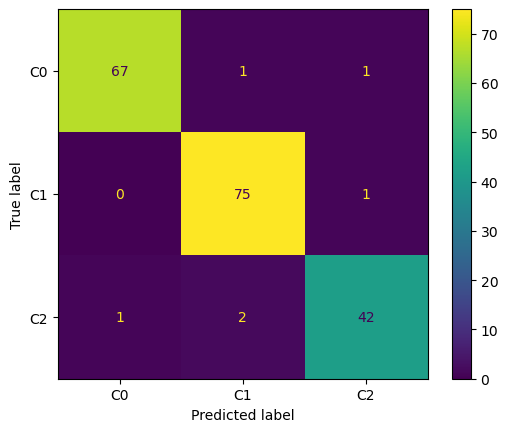

In [22]:
class_names = ['C0', 'C1', 'C2']
predictions = clf.predict(X_test)
metrics.ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test, display_labels=class_names)
#plt.show()

# save figures
plt.savefig("ConfusionMatrix.pdf")

In [85]:
clf.predict(X_test[:20])

array([1, 0, 2, 0, 1, 2, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1])

In [86]:
y_test[:20]

[1, 0, 2, 0, 1, 2, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1]

### 3. Training the final model

In [58]:
clf = svm.SVC(kernel='linear', C=1, probability=True, random_state=100).fit(kirc_gsea_scaled.values, labels)

### 4. Model persistence

In [132]:
# dump(clf, 'ccRCC_classifier.joblib')
# dump(scaler, 'ccRCC_scaler.joblib') 

['ccRCC_scaler.joblib']

### 5. Predicting new cases

In [6]:
# loading model
clf = load('ccRCC_classifier.joblib')
scaler = load('ccRCC_scaler.joblib')

In [7]:
# loading test data
test_gsea = pd.read_csv('cell_lines/RCC_gsea_scores.csv', index_col=0)
test_gsea = test_gsea.drop('Sample_Type', axis=1)
test_gsea

,RBPJL,SNAI2,PAX5,RARB,WT1,EGR1,RBPJ,LEF1,ARNT,CREB1,SRF,MEF2C,EPAS1,GATA4,HIF1A,PAX8,AHR
A704,0.142814,-0.171404,-0.154889,0.133738,-0.024173,0.115477,0.051750,-0.124323,0.292179,0.031417,0.095700,-0.071812,-0.164779,-0.098909,-0.213152,0.075362,0.483736
RXF393,0.035207,-0.024792,0.024808,0.234558,-0.033575,0.140198,0.130943,-0.033926,0.240031,0.047359,0.375146,0.025840,-0.036028,-0.204068,-0.091388,-0.098170,0.506122
SN12C,0.072848,-0.135261,-0.114207,0.245356,0.105172,0.049893,0.083878,0.013139,0.023664,0.040705,0.274807,-0.005097,-0.303668,-0.102024,-0.007584,-0.004762,0.199286
U031,0.025669,-0.190507,0.012133,0.234215,0.075752,0.082538,0.107508,-0.082066,0.113610,0.023036,0.244350,-0.086904,-0.175034,-0.246571,-0.049686,0.000730,0.266597
X786.0,0.027238,-0.105483,-0.025936,0.119171,0.079270,0.098762,0.077316,-0.015653,0.096354,0.071899,0.210199,-0.061913,-0.139208,-0.146411,-0.067483,-0.171180,0.247346
BB65.RCC,0.120295,-0.186489,-0.027141,0.131450,0.020781,0.114758,0.096368,-0.178152,0.229850,0.046793,0.217283,-0.024812,-0.098588,-0.152151,-0.160215,0.083003,0.260584
LB996.RCC,0.031775,-0.219694,-0.093791,0.200443,0.034745,0.092739,0.145382,-0.179102,0.216287,0.027009,0.239438,-0.071368,-0.223440,-0.264658,-0.058746,0.006023,0.282028
TK10,0.071250,-0.197704,-0.068931,0.106407,0.038292,0.047913,0.080591,-0.149819,0.091922,0.065389,0.172745,-0.072213,-0.269502,-0.094578,-0.031783,0.063082,0.156605
HA7.RCC,0.091167,-0.139815,0.063065,0.155123,0.012291,0.111131,0.098409,-0.139597,0.098221,0.046590,0.164054,-0.051908,-0.177815,-0.068943,-0.129946,0.055383,0.240923
LB2241.RCC,0.077279,-0.316214,-0.354460,0.222190,0.032419,0.090327,0.070870,-0.084371,0.042939,0.028393,0.316505,0.007625,-0.186961,-0.045241,-0.117962,0.116396,0.018833


In [8]:
test_samples = list(test_gsea.index)

In [9]:
test_gsea_scaled = scaler.transform(test_gsea) # standardization of data

In [10]:
test_scaled_df = pd.DataFrame(test_gsea_scaled, columns=test_gsea.columns)
test_scaled_df

,RBPJL,SNAI2,PAX5,RARB,WT1,EGR1,RBPJ,LEF1,ARNT,CREB1,SRF,MEF2C,EPAS1,GATA4,HIF1A,PAX8,AHR
0,1.182426,-1.282013,-1.482624,-0.074538,1.752157,-0.884666,-3.137119,1.234801,1.109895,-2.113536,-1.885455,0.173972,-1.485703,2.516157,0.212361,-0.151388,1.544197
1,-1.113373,0.583973,0.502091,1.630948,1.553815,-0.280317,-0.592228,2.986418,0.344914,-1.716717,1.885105,1.243452,0.412007,1.225779,2.648217,-3.008667,1.707211
2,-0.310305,-0.822008,-1.033295,1.813609,4.480874,-2.488011,-2.104690,3.898396,-2.829095,-1.882339,0.531239,0.904626,-3.532830,2.477935,4.324706,-1.470662,-0.527136
3,-1.316860,-1.525142,0.362093,1.625147,3.860220,-1.689927,-1.345311,2.053619,-1.509625,-2.322130,0.120279,0.008681,-1.636849,0.704233,3.482469,-1.380235,-0.036988
4,-1.283389,-0.443012,-0.058366,-0.320959,3.934435,-1.293308,-2.315560,3.340489,-1.762760,-1.105900,-0.340521,0.282382,-1.108797,1.933265,3.126440,-4.210790,-0.177173
5,0.701985,-1.474007,-0.071682,-0.113241,2.700525,-0.902251,-1.703315,0.191759,0.195567,-1.730802,-0.244932,0.688713,-0.510076,1.862832,1.271347,-0.025584,-0.080773
6,-1.186589,-1.896616,-0.807814,1.053860,2.995110,-1.440543,-0.128206,0.173361,-0.003404,-2.223254,0.054003,0.178833,-2.350326,0.482299,3.301212,-1.293079,0.075380
7,-0.344390,-1.616744,-0.533239,-0.536877,3.069932,-2.536407,-2.210319,0.740771,-1.827785,-1.267942,-0.845883,0.169577,-3.029245,2.569295,3.840612,-0.353586,-0.837939
8,0.080537,-0.879966,0.924626,0.287220,2.521409,-0.990903,-1.637715,0.938833,-1.735369,-1.735877,-0.963146,0.391959,-1.677845,2.883853,1.876884,-0.480360,-0.223945
9,-0.215756,-3.125071,-3.686841,1.421733,2.946053,-1.499498,-2.522698,2.008956,-2.546334,-2.188808,1.093861,1.043954,-1.812646,3.174698,2.116612,0.524248,-1.841179


In [28]:
print('The predicted class is: C{}'.format(clf.predict(test_gsea_scaled)[0])) # predict labels for each sample

The predicted class is: C0


In [11]:
pred_res = pd.DataFrame(clf.predict(test_gsea_scaled), index=test_samples, columns=['Predicted_Class'])
#pred_res.to_csv('ccRCC_Tokyo/ccRCC_pred.csv')
#pred_res.to_csv('cell_lines/RCC_pred.csv')

In [29]:
probs = clf.predict_proba(test_gsea_scaled) # gives probabilities for each sample
print('The predicted class probabilities are: C0_Prob = {},  C1_Prob = {},  C2_Prob = {}'.format(probs[0, 0], probs[0, 1], probs[0, 2]))

The predicted class probabilities are: C0_Prob = 0.9998908373043189,  C1_Prob = 3.35462432771644e-05,  C2_Prob = 7.561645240395325e-05


In [30]:
svm_scores = clf.decision_function(test_gsea_scaled) # gives per-class scores for each sample
print('The predicted SVM scores are: C0_Score = {},  C1_Score = {},  C2_Score = {}'.format(svm_scores[0, 0], svm_scores[0, 1], svm_scores[0, 2]))

The predicted SVM scores are: C0_Score = 2.308184352704303,  C1_Score = -0.2977226562291878,  C2_Score = 0.7347792379482647


### 6. Explaining

In [ ]:
shap.initjs()

In [32]:
explainer = shap.KernelExplainer(clf.predict_proba, kirc_gsea_scaled)

Using 475 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


### 6.1 explain the predicting model itself

In [105]:
shap_values = explainer(kirc_gsea_scaled)

  0%|          | 0/475 [00:00<?, ?it/s]

In [111]:
explained_class_idx = 0 # can be 0, 1, or 2
plt.clf()
shap.plots.beeswarm(shap_values[:,:,explained_class_idx], max_display=17, show=False)
plt.savefig("explain_TCGA_KIRC_C2.pdf", bbox_inches='tight')

### 6.2 explain Tokyo-ccRCC cases

In [113]:
shap_values = explainer(test_gsea_scaled) # test_gsea_scaled is standarized Tokyo ccRCC data (ccRCC_Tokyo/ccRCC_gsea_scores.csv as input)

  0%|          | 0/101 [00:00<?, ?it/s]

In [140]:
case_idx = 2 # i.e. ccRCC-xx
pred_res.iloc[case_idx, :]

Predicted_Class    2
Name: ccRCC.3, dtype: int32

In [141]:
explained_class_idx = pred_res.iloc[case_idx, 0]


plot_expainer = shap.Explanation(values=shap_values[case_idx, :, explained_class_idx],
                                 base_values=explainer.expected_value[explained_class_idx], 
                                 data=test_gsea_scaled[case_idx], 
                                 feature_names=features)

plt.figure(figsize=(10, 4))
shap.plots.waterfall(plot_expainer, show=False)

plt.savefig('ccRCC_Tokyo/explain_Tokyo_{}.pdf'.format(pred_res.index[case_idx]), bbox_inches='tight', pad_inches=1)

### 6.3 explain cell line cases

In [153]:
shap_values = explainer(test_gsea_scaled) # test_gsea_scaled is standarized cell line data (cell_lines/KMRC_20_gsea_scores.csv as input)

  0%|          | 0/1 [00:00<?, ?it/s]

In [154]:
case_idx = 0 # i.e. KMRC-20
pred_res.iloc[case_idx, :]

Predicted_Class    0
Name: KMRC-20, dtype: int32

In [155]:
explained_class_idx = pred_res.iloc[case_idx, 0]

plot_expainer = shap.Explanation(values=shap_values[case_idx, :, explained_class_idx], 
                                 base_values=explainer.expected_value[explained_class_idx], 
                                 data=test_gsea_scaled[case_idx], 
                                 feature_names=features)

plt.figure(figsize=(10, 4))
shap.plots.waterfall(plot_expainer, show=False)

plt.savefig("cell_lines/explain_{}.pdf".format(pred_res.index[case_idx]), bbox_inches='tight', pad_inches=1)

In [167]:
shap.plots.force(explainer.expected_value[explained_class_idx], 
                 shap_values.values[case_idx, :, explained_class_idx], 
                 test_gsea_scaled[case_idx], 
                 feature_names = features, 
                 matplotlib=False, show=True)
#plt.savefig("explain_force_KMRC-20.pdf", bbox_inches='tight', pad_inches=1)